In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [2]:
n_repeats = 10

In [3]:
def get_dset(filename, label_name, col_names=None):
    dset = pd.read_csv(f'data/{filename}', header=None if col_names else 0)
    
    if col_names is not None:
        dset.columns = col_names

    X = dset.drop(label_name, axis=1).values
    y = dset[label_name]

    return X, y


In [4]:
def exp_crossvalidation_test(filename, label_name, col_names=None, title=""):
    X, y = get_dset(filename, label_name, col_names)

    # Cross validation
    n_splits_list = [2, 5, 10]
    stratify_list = [True, False]

    knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
        
    x_data = []
    f_score_data = []
    results = []
    for n_splits in n_splits_list:
        for stratified in stratify_list:
            for _ in range(n_repeats):
                f_scores = []
                accuracies = []

                if stratified:
                    kf = StratifiedKFold(n_splits = n_splits, shuffle = True)
                else:
                    kf = KFold(n_splits = n_splits, shuffle = True)

                if stratified:
                    for train_index, test_index in kf.split(X, y):
                        X_train, X_test = X[train_index], X[test_index]
                        y_train, y_test = y[train_index], y[test_index]

                        scaler = StandardScaler()
                        X_train = scaler.fit_transform(X_train)
                        X_test = scaler.transform(X_test) 
                        knn.fit(X_train, y_train)

                        y_pred = knn.predict(X_test)
                        f_scores.append(f1_score(y_test, y_pred, average="micro"))
                        accuracies.append(accuracy_score(y_test, y_pred))
                else:
                    for train_index, test_index in kf.split(X):
                        X_train, X_test = X[train_index], X[test_index]
                        y_train, y_test = y[train_index], y[test_index]

                        scaler = StandardScaler()
                        X_train = scaler.fit_transform(X_train)
                        X_test = scaler.transform(X_test) 
                        knn.fit(X_train, y_train)

                        y_pred = knn.predict(X_test)
                        f_scores.append(f1_score(y_test, y_pred, average="micro"))
                        accuracies.append(accuracy_score(y_test, y_pred))

                f_score = np.mean(f_scores)
                accuracy = np.mean(accuracies)

                results.append(f_score)
            
            x_data.append(f'{n_splits} folds{" stratified" if stratified else ""}')
            f_score_data.append(np.mean(results))

    f_score_data, x_data = zip(*sorted(zip(f_score_data, x_data), reverse=True))
    plt.figure(figsize=(10, 5))
    plt.bar(x_data, f_score_data)
    plt.ylim((0.7, 1))
    plt.xlabel('Parametry walidacji krzyzowej')
    plt.ylabel('F score')
    plt.title(f'Wplyw parametrow walidacji krzyzowej na skutecznosc k-nn dla {title}')
    plt.show()
    
    print(pd.DataFrame({'Params': x_data, 'F score': f_score_data}))
    
wine_col_names = ['Class identifier', 'Alcohol', 'Malic acid', 'Ash', 
                  'Alcalinity of ash', 'Magnesium', 
                  'Total phenols', 'Flavanoids', 
                  'Nonflavanoid phenols', 'Proanthocyanins', 
                  'Color intensity', 'Hue', 
                  'OD280/OD315 of diluted wines', 'Proline']

glass_col_names = ['Id', 'RI', 'Na', 'Mg', 'Al',
                  'Si', 'K', 'Ca', 'Ba', 'Fe', 'type']


In [5]:
def exp_n_neighbors_test(filename, label_name, col_names=None, title="", n_folds=10):
    X, y = get_dset(filename, label_name, col_names)

    # Cross validation
    n_neighbors_list = np.arange(1, 17, 1)
    
    x_data = []
    f_score_data = []

    for n_neighbors in n_neighbors_list:
        results = []
        for _ in range(n_repeats):
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
            f_scores = []
            accuracies = []

            kf = StratifiedKFold(n_splits = n_folds, shuffle = True)

            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test) 
                knn.fit(X_train, y_train)

                y_pred = knn.predict(X_test)
                f_scores.append(f1_score(y_test, y_pred, average="micro"))
                accuracies.append(accuracy_score(y_test, y_pred))

            f_score = np.mean(f_scores)
            accuracy = np.mean(accuracies)
            results.append(f_score)

        x_data.append(n_neighbors)
        f_score_data.append(results)
        #f_score_data.append(f_scores)
        # f_score_data.append(f_score)
    
    #f_score_data, x_data = zip(*sorted(zip(f_score_data, x_data), reverse=True))
    df = pd.DataFrame({'Parameters': x_data, 'F1_score (mean)': [round(np.mean(x), 2) for x in f_score_data]})
    print(df.sort_values('F1_score (mean)', ascending=False))
    plt.figure(figsize=(10, 5))
    plt.boxplot(f_score_data)
    plt.xticks(np.arange(1, len(x_data) + 1, 1), x_data)
    # plt.ylim((0.8, 1))
    plt.xlabel('Liczba sąsiadów')
    plt.ylabel('F score')
    plt.title(f'Wplyw liczby sąsiadów w algorytmie k-nn na jego skutecznosc dla {title}')
    plt.show()
    
    print(y.value_counts())
    
wine_col_names = ['Class identifier', 'Alcohol', 'Malic acid', 'Ash', 
                  'Alcalinity of ash', 'Magnesium', 
                  'Total phenols', 'Flavanoids', 
                  'Nonflavanoid phenols', 'Proanthocyanins', 
                  'Color intensity', 'Hue', 
                  'OD280/OD315 of diluted wines', 'Proline']

glass_col_names = ['Id', 'RI', 'Na', 'Mg', 'Al',
                  'Si', 'K', 'Ca', 'Ba', 'Fe', 'type']


In [6]:
def exp_metric_test(filename, label_name, col_names=None, title="", n_folds=10, n_neighbors=5, voting='uniform'):
    X, y = get_dset(filename, label_name, col_names)

    metric_list = ['euclidean', 'manhattan', 'minkowski']
    
    x_data = []
    f_score_data = []
    for metric in metric_list:
        results = []
        for _ in range(n_repeats):
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=voting)
            f_scores = []
            accuracies = []

            kf = StratifiedKFold(n_splits = n_folds, shuffle = True)

            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test) 
                knn.fit(X_train, y_train)

                y_pred = knn.predict(X_test)
                f_scores.append(f1_score(y_test, y_pred, average="micro"))
                accuracies.append(accuracy_score(y_test, y_pred))

            f_score = np.mean(f_scores)
            accuracy = np.mean(accuracies)
            results.append(f_score)

        x_data.append(metric)
        f_score_data.append(results)#f_scores)
    
    df = pd.DataFrame({'Parameters': x_data, 'F1_score (mean)': [round(np.mean(x), 2) for x in f_score_data]})
    print(df.sort_values('F1_score (mean)', ascending=False))
    plt.figure(figsize=(10, 5))
    plt.boxplot(f_score_data)
    plt.xticks(np.arange(1, len(x_data) + 1, 1), x_data)
    # plt.ylim((0.8, 1))
    plt.xlabel('Miara odleglosci')
    plt.ylabel('F score')
    plt.title(f'Wplyw miary odleglosci w algorytmie k-nn na jego skutecznosc dla {title}')
    plt.show()
    
wine_col_names = ['Class identifier', 'Alcohol', 'Malic acid', 'Ash', 
                  'Alcalinity of ash', 'Magnesium', 
                  'Total phenols', 'Flavanoids', 
                  'Nonflavanoid phenols', 'Proanthocyanins', 
                  'Color intensity', 'Hue', 
                  'OD280/OD315 of diluted wines', 'Proline']

glass_col_names = ['Id', 'RI', 'Na', 'Mg', 'Al',
                  'Si', 'K', 'Ca', 'Ba', 'Fe', 'type']


In [7]:
def my_distance(weights):
    suma = sum(weights)
    return [1 - (x/suma) for x in weights]

def exp_voting_test(filename, label_name, col_names=None, title="", n_folds=10, n_neighbors=5):
    X, y = get_dset(filename, label_name, col_names)

    n_splits = 5
    voting_list = ['uniform', 'distance', 'own']
    
    x_data = []
    f_score_data = []
    for voting in voting_list:
        results = []
        for _ in range(n_repeats):
            if voting == 'own':
                knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean', weights=my_distance)
            else:
                knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean', weights=voting)
            f_scores = []
            accuracies = []

            kf = StratifiedKFold(n_splits = n_folds, shuffle = True)

            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test) 
                knn.fit(X_train, y_train)

                y_pred = knn.predict(X_test)
                f_scores.append(f1_score(y_test, y_pred, average="micro"))
                accuracies.append(accuracy_score(y_test, y_pred))

            f_score = np.mean(f_scores)
            accuracy = np.mean(accuracies)
            results.append(f_score)

        x_data.append(voting)
        f_score_data.append(results)#f_scores)
    
    df = pd.DataFrame({'Parameters': x_data, 'F1_score (mean)': [round(np.mean(x), 2) for x in f_score_data]})
    print(df.sort_values('F1_score (mean)', ascending=False))
    plt.figure(figsize=(10, 5))
    plt.boxplot(f_score_data)
    plt.xticks(np.arange(1, len(x_data) + 1, 1), x_data)
    # plt.ylim((0.8, 1))
    plt.xlabel('Liczba sasiadow')
    plt.ylabel('F score')
    plt.title(f'Wplyw sposobu glosowania w algorytmie k-nn na jego skutecznosc dla {title}')
    plt.show()
    
wine_col_names = ['Class identifier', 'Alcohol', 'Malic acid', 'Ash', 
                  'Alcalinity of ash', 'Magnesium', 
                  'Total phenols', 'Flavanoids', 
                  'Nonflavanoid phenols', 'Proanthocyanins', 
                  'Color intensity', 'Hue', 
                  'OD280/OD315 of diluted wines', 'Proline']

glass_col_names = ['Id', 'RI', 'Na', 'Mg', 'Al',
                  'Si', 'K', 'Ca', 'Ba', 'Fe', 'type']


### Wszystkie badania uruchomiono 10-krotnie, a wyniki uśredniono!

## IRIS


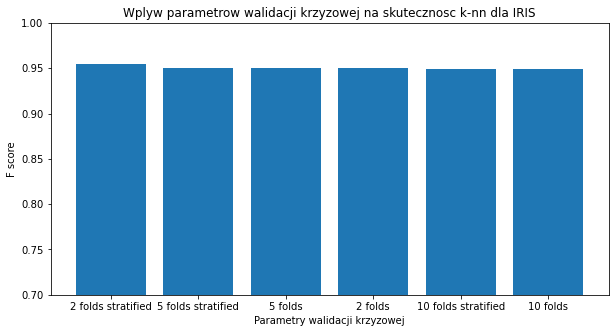

                Params   F score
0   2 folds stratified  0.954667
1   5 folds stratified  0.950444
2              5 folds  0.950000
3              2 folds  0.950000
4  10 folds stratified  0.949467
5             10 folds  0.949222


In [8]:
exp_crossvalidation_test('iris.csv', 'variety', title='IRIS')

Uruchomiono badania stosując różne sposoby walidacji krzyżowej. Przeprowadzone badanie wykazało, że w przypadku zbioru danych IRIS, wyniki są na tyle zbliżone do siebie, że parametryzacja walidacji krzyżowej praktycznie nie ma znaczenia. W dalszych badaniach stosowana będzie walidacja o liczbie foldów 10, ze stratyfikacją.

    Parameters  F1_score (mean)
13          14             0.97
15          16             0.97
6            7             0.96
7            8             0.96
10          11             0.96
11          12             0.96
12          13             0.96
14          15             0.96
0            1             0.95
1            2             0.95
2            3             0.95
4            5             0.95
5            6             0.95
8            9             0.95
9           10             0.95
3            4             0.94


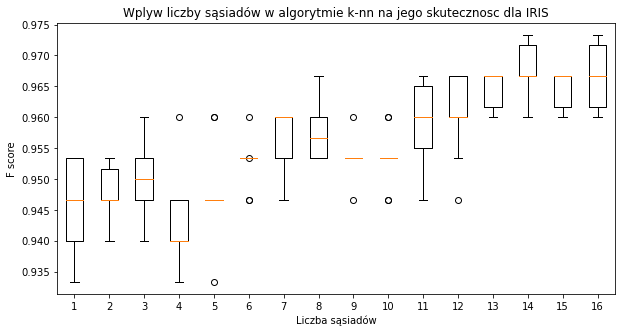

Setosa        50
Versicolor    50
Virginica     50
Name: variety, dtype: int64


In [9]:
exp_n_neighbors_test('iris.csv', 'variety', title='IRIS', n_folds=10)

Z powyższego wykresu można wywnioskować, że najlepsze wyniki osiągnięto w przypadku liczby sąsiadów równej 16. Pozwala to stwierdzić, że dane w zbiorze IRIS faktycznie przynależą do grup bezpośrednio na podstawie opisanych cech i są bardzo podobne do swoich sąsiadów.

  Parameters  F1_score (mean)
0    uniform             0.96
1   distance             0.96
2        own             0.96


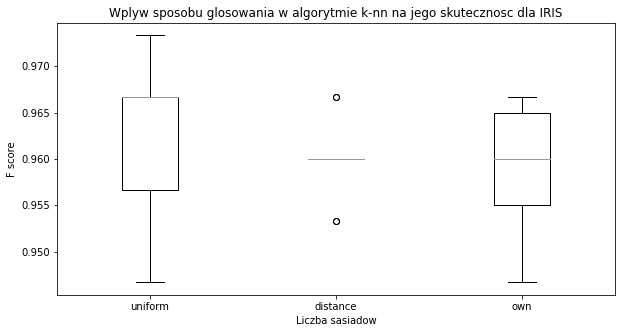

In [10]:
exp_voting_test('iris.csv', 'variety', title='IRIS', n_folds=10, n_neighbors=16)

W przypadku zbioru danych IRIS, najlepszy wynik osiągnięto stosując domyślny sposób głosowania.
Moja własna funkcja głosowania - obliczanie nowych wartości odległości za pomocą wzoru: 1 - odleglosc/(suma_odległości) - sprawdziła się minimalnie gorzej od domyślnych metod.


  Parameters  F1_score (mean)
2  minkowski             0.97
0  euclidean             0.96
1  manhattan             0.95


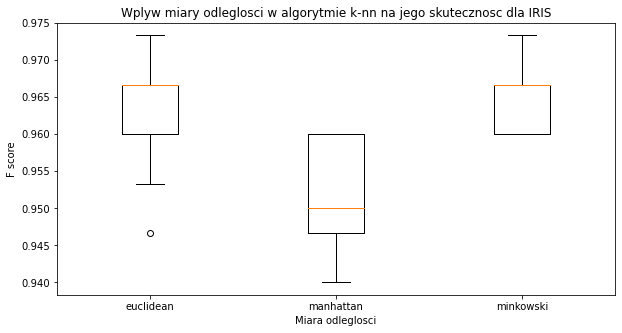

In [11]:
exp_metric_test('iris.csv', 'variety', title='IRIS', n_folds=10, n_neighbors=16, voting='uniform')

Dla zbioru danych IRIS najlepszy wynik osiągnięto stosując miarę euklidesową.

## WINE

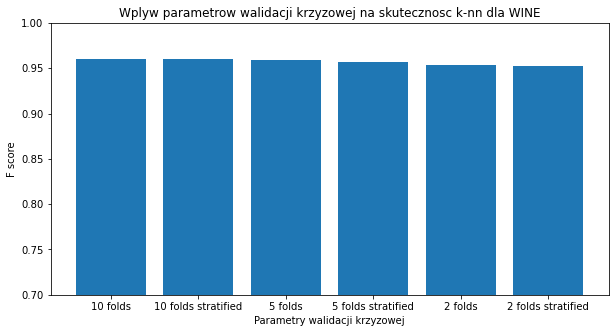

                Params   F score
0             10 folds  0.960773
1  10 folds stratified  0.960575
2              5 folds  0.958995
3   5 folds stratified  0.956581
4              2 folds  0.953371
5   2 folds stratified  0.952247


In [12]:
exp_crossvalidation_test('wine.data', 'Class identifier', wine_col_names, title='WINE')

Podobnie jak dla zbioru IRIS, wpływ parametryzacji walidacji krzyżowej był bardzo niewielki na wyniki.

    Parameters  F1_score (mean)
4            5             0.97
6            7             0.97
8            9             0.97
9           10             0.97
10          11             0.97
14          15             0.97
15          16             0.97
5            6             0.96
7            8             0.96
11          12             0.96
12          13             0.96
13          14             0.96
0            1             0.95
2            3             0.95
3            4             0.95
1            2             0.94


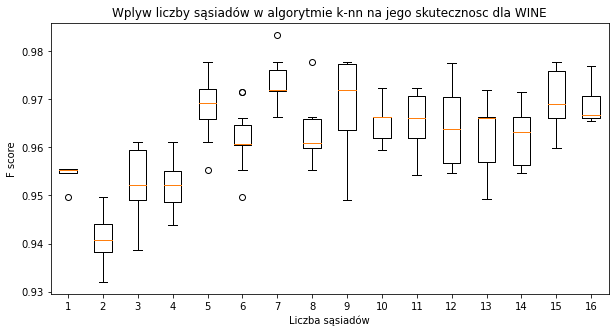

2    71
1    59
3    48
Name: Class identifier, dtype: int64


In [13]:
exp_n_neighbors_test('wine.data', 'Class identifier', wine_col_names, title='WINE', n_folds=10)


Wyniki są już znacznie mniej oczywiste niż w przypadku IRIS - wykres nie jest taki regularny i wyniki zdają się pogarszać w przypadku większej liczby sąsiadów. Najlepsze i całkiem stabilne wyniki uzyskano dla liczby sąsiadów równej 5, dlatego taki parametr wykorzystano w dalszych badaniach. Zbiór ten charakteryzuje się niższym zbalansowaniem pod kątem klas w porównaniu do IRIS.

  Parameters  F1_score (mean)
0    uniform             0.97
1   distance             0.97
2        own             0.97


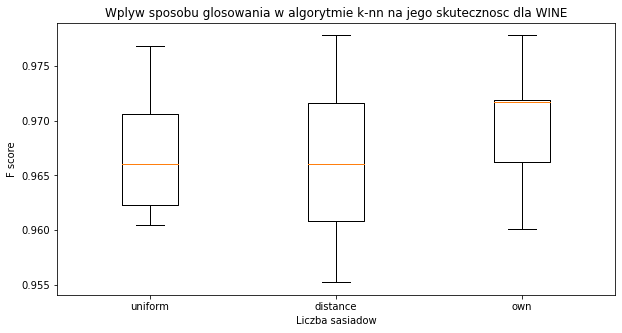

In [14]:
exp_voting_test('wine.data', 'Class identifier', wine_col_names, title='WINE', n_neighbors=5, n_folds=10)

Wszystkie 3 sposoby głosowania osiągają podobne wyniki.

  Parameters  F1_score (mean)
0  euclidean             0.97
1  manhattan             0.97
2  minkowski             0.97


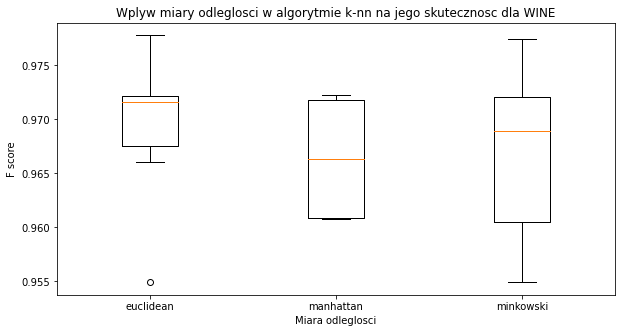

In [15]:
exp_metric_test('wine.data', 'Class identifier', wine_col_names, title='WINE', n_neighbors=5, n_folds=10, voting='uniform')

Ze względu na bardzo wysokie wartości f1_score uzyskiwane przez modele, miara odległości nie wpłynęła zbytnio na osiągane rezultaty.

## GLASS

C:\Users\Robert\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Robert\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Robert\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Robert\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Robert\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Robert\anac

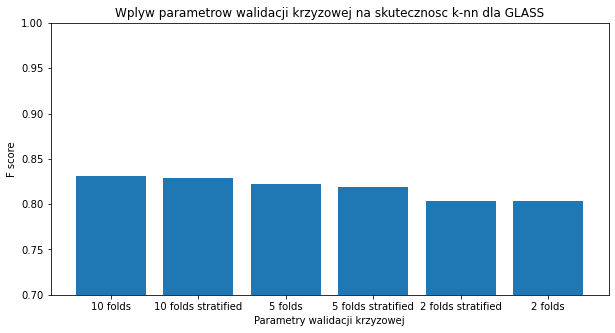

                Params   F score
0             10 folds  0.831585
1  10 folds stratified  0.829231
2              5 folds  0.822756
3   5 folds stratified  0.819020
4   2 folds stratified  0.803738
5              2 folds  0.803037


In [16]:
exp_crossvalidation_test('glass.data', 'type', glass_col_names, title='GLASS')

Różnice w wynikach są znacznie większe niż w przypadku poprzednich zbiorów. Ze względu na bardzo niską liczność jednej z klas w zbiorze GLASS, wynoszącą 9, wyniki walidacji krzyżowej dla 10 foldów są niemiarodajne. W dalszych badaniach wykorzystano liczbę foldów równą 5.

    Parameters  F1_score (mean)
0            1             0.86
2            3             0.86
3            4             0.85
4            5             0.85
5            6             0.83
6            7             0.83
1            2             0.82
7            8             0.82
8            9             0.81
9           10             0.80
10          11             0.80
11          12             0.80
12          13             0.80
13          14             0.79
14          15             0.79
15          16             0.77


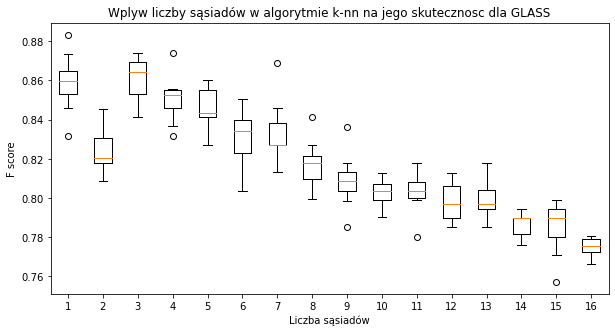

2    76
1    70
7    29
3    17
5    13
6     9
Name: type, dtype: int64


In [17]:
exp_n_neighbors_test('glass.data', 'type', glass_col_names, title='GLASS', n_folds=5)

W przypadku zbioru danych GLASS wyniki są znacznie inne niż dla zbiorów IRIS i WINE. Wyniki pogarszają się wraz ze wzrostem liczby sąsiadów. Wynika to przede wszystkim z mocnego niezbalansowania klas - dwie najbardziej liczne klasy mają ponad 70 przypadków, poczas gdy suma przypadków w pozostałych klasach jest mniejsza od tej wartości. W zbiorze występuje również dość duża liczba klas, o mocno mieszających się własnościach co utrudnia identyfikację. W dalszych badaniach zastosowano liczbę sąsiadów równą 3.

  Parameters  F1_score (mean)
1   distance             0.87
0    uniform             0.86
2        own             0.86


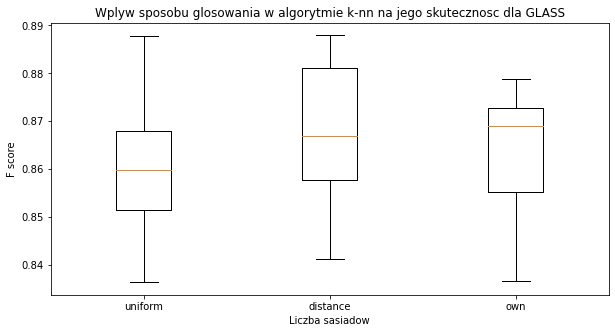

In [18]:
exp_voting_test('glass.data', 'type', glass_col_names, title='GLASS', n_folds=5, n_neighbors=3)

W przypadku zbioru danych distance zmiana sposobu głosowania na ważony jednoznacznie poprawiła wyniki modelu. Sposób głosowania "distance" zwiększa znaczenie najbliższych sąsiadów, co w przypadku niezbalansowanego zbioru o dużych różnicach w cechach jest rozsądnym rozwiazaniem.

  Parameters  F1_score (mean)
1  manhattan             0.91
2  minkowski             0.88
0  euclidean             0.87


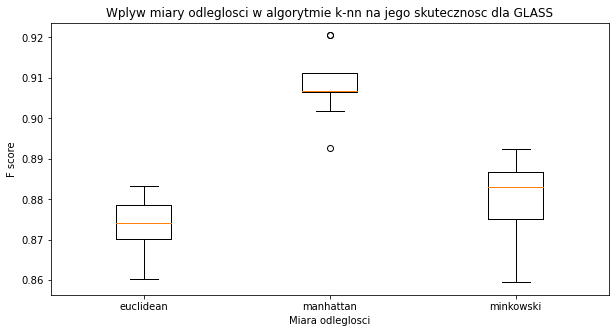

In [19]:
exp_metric_test('glass.data', 'type', glass_col_names, title='GLASS', n_neighbors=3, n_folds=5, voting='distance')

Zmiana sposobu mierzenia odległości znacząco poprawiła osiągane rezultaty. Miara Manhattan uzyskała imponującą wartość f score równą 0.90. 

### Porównanie zbiorów
Uzyskane wyniki pozwalają stwierdzić, że każdy ze zbiorów reaguje inaczej na zmianę parametrów - najbardziej było to widoczne w przypadku liczby sąsiadów. Wynika to przede wszystkim z liczby klas, a także rozkładów osobników w tych klasach i jednoznaczności przypisania do klas na podstawie cech. Warto zauważyć, że zbiory te były bardzo małe, co również wpływa istotnie na identyfikację sąsiedztwa ze względu na nieduże pokrycie zakresów wartości w poszczególnych wymiarach. W przypadku zbioru danych IRIS, pozostałe parametry miały niewielkie znaczenie, podczas gdy dla WINE zmieniając sposób głosowania oraz miarę odległości uzyskano wynik aż o 0.04 więcej. 